In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from feature_extraction import *
from helper import *

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from moviepy.editor import VideoFileClip

%matplotlib inline

C:\Users\JINGR1\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Images

In [2]:
vehicle_files_dir = './vehicles/'
non_vehicle_files_dir = './non-vehicles/'

vehicle_files = extract_files(vehicle_files_dir)
non_vehicle_files = extract_files(non_vehicle_files_dir)

print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

Number of vehicle files: 8792
Number of non-vehicle files: 8968


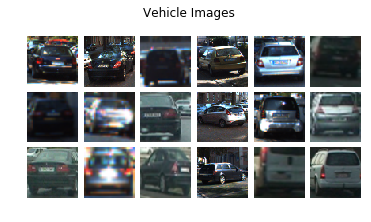

In [3]:
display_random_images(vehicle_files, num_of_images=18, main_title='Vehicle Images')

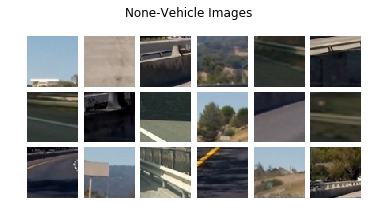

In [4]:
display_random_images(non_vehicle_files, num_of_images=18, main_title='None-Vehicle Images')

# Feature Extraction

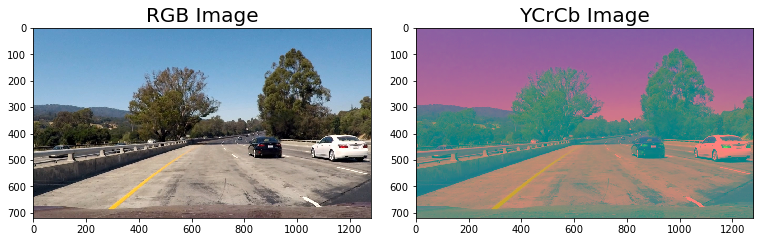

In [5]:
#random_num = np.random.randint(0,len(vehicle_files))
#img = mpimg.imread(vehicle_files[random_num])
img = mpimg.imread('test_images/test1.jpg')
image = convert_color(img, conv='RGB2YCrCb')
display_comparison_diagram(img,image, figsize = (10,5), fontsize = 20, img1_title = 'RGB Image',img2_title = 'YCrCb Image')

## Spacial Bins Feature Extraction

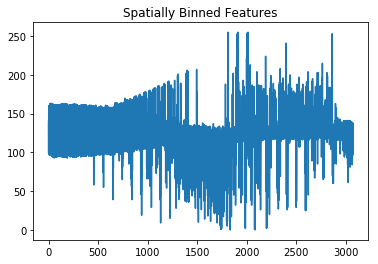

In [6]:
spatial_features = bin_spatial(image)
# Plot features
plt.plot(spatial_features)
plt.title('Spatially Binned Features')

## Color Histograms Features Extraction

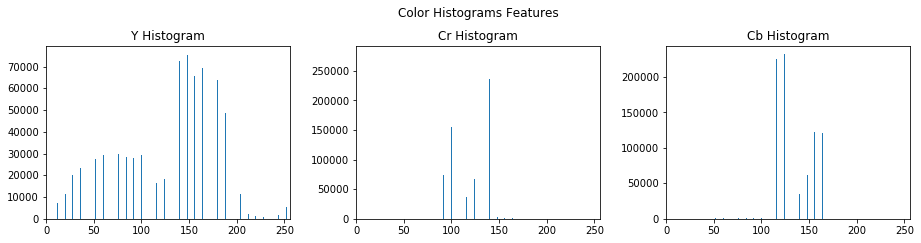

In [7]:
channel1_hist,channel2_hist,channel3_hist,bin_centers,hist_features = color_hist(image,vis = True)
# Plot a figure with all three bar charts
if channel1_hist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel3_hist[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
    plt.suptitle('Color Histograms Features')

## HOG Features Extraction

In [8]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_images = []
for channel in range(image.shape[2]):
    hog_images.append(get_hog_features(image[:,:,channel],
                        orient, pix_per_cell, cell_per_block,
                        vis=True, feature_vec=True)[1])

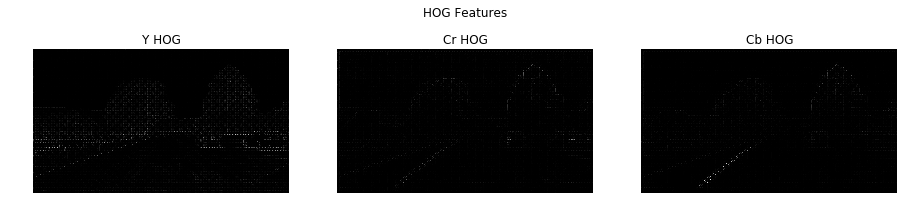

In [9]:
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.axis('off')
plt.imshow(hog_images[0],cmap='gray')
plt.title('Y HOG')
plt.subplot(132)
plt.axis('off')
plt.imshow(hog_images[1],cmap='gray')
plt.title('Cr HOG')
plt.subplot(133)
plt.axis('off')
plt.imshow(hog_images[2],cmap='gray')
plt.title('Cb HOG')
fig.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.suptitle('HOG Features')

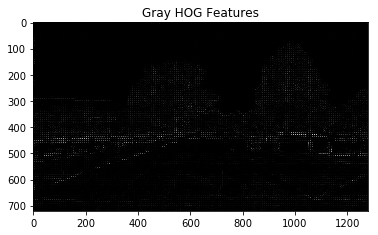

In [10]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

features, hog_image = get_hog_features(gray, orient, 
                    pix_per_cell, cell_per_block, 
                    vis=True, feature_vec=False)
plt.imshow(hog_image,cmap='gray')
plt.title('Gray HOG Features')

In [11]:
vehicles = []
vehicles_hog_features = []

for i in range(1):
    rnd_idx = np.random.randint(1, len(vehicle_files))
    img = mpimg.imread(vehicle_files[rnd_idx])
    image = convert_color(img, conv='RGB2YCrCb')
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    for channel in range(image.shape[2]):
        vehicles_hog_features.append(get_hog_features(image[:,:,channel],
                            orient, pix_per_cell, cell_per_block,
                            vis=True, feature_vec=True)[1])
        vehicles.append(image[:,:,channel])
        
        
non_vehicles = []
non_vehicles_hog_features = []

for i in range(1):
    rnd_idx = np.random.randint(1, len(non_vehicle_files))
    img = mpimg.imread(non_vehicle_files[rnd_idx])
    image = convert_color(img, conv='RGB2YCrCb')
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    for channel in range(image.shape[2]):
        non_vehicles_hog_features.append(get_hog_features(image[:,:,channel],
                            orient, pix_per_cell, cell_per_block,
                            vis=True, feature_vec=True)[1])
        non_vehicles.append(image[:,:,channel])

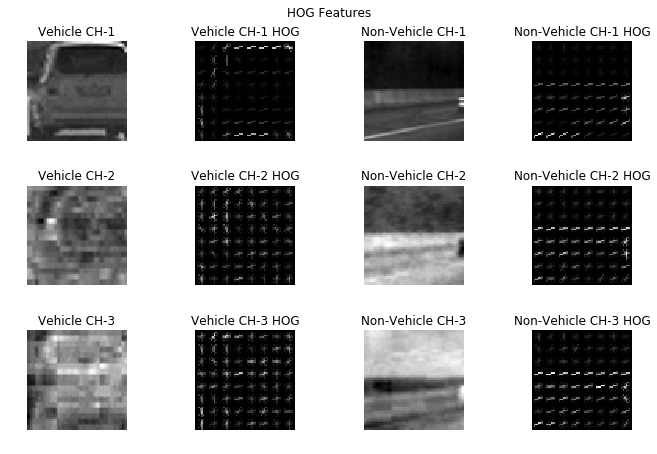

In [12]:
fig = plt.figure(figsize=(9,6))
for i in range(len(vehicles)):
    plt.subplot(3,4,1+i*4)
    plt.axis('off')
    plt.imshow(vehicles[i],cmap='gray')
    plt.title('Vehicle CH-{}'.format(i+1))
    
for i in range(len(vehicles_hog_features)):
    plt.subplot(3,4,2+i*4)
    plt.axis('off')
    plt.imshow(vehicles_hog_features[i],cmap='gray')
    plt.title('Vehicle CH-{} HOG'.format(i+1))
    
for i in range(len(vehicles)):
    plt.subplot(3,4,3+i*4)
    plt.axis('off')
    plt.imshow(non_vehicles[i],cmap='gray')
    plt.title('Non-Vehicle CH-{}'.format(i+1))
    
for i in range(len(vehicles_hog_features)):
    plt.subplot(3,4,4+i*4)
    plt.axis('off')
    plt.imshow(non_vehicles_hog_features[i],cmap='gray')
    plt.title('Non-Vehicle CH-{} HOG'.format(i+1))
    
fig.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.suptitle('HOG Features')

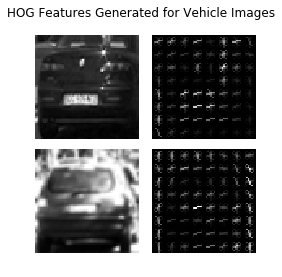

In [13]:
vehicles = []
vehicles_hog_features = []

for i in range(2):
    rnd_idx = np.random.randint(1, len(vehicle_files))
    image = mpimg.imread(vehicle_files[rnd_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    vehicles.append(hog_image)
    vehicles_hog_features.append(gray)

visualize_hog_features(vehicles, vehicles_hog_features, 
                              color_map='gray', 
                              suptitle='HOG Features Generated for Vehicle Images')

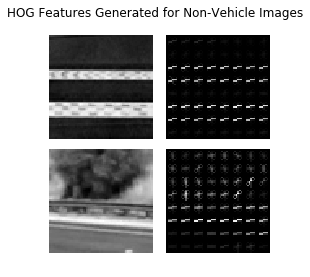

In [14]:
non_vehicles = []
non_vehicles_hog_features = []

for i in range(2):
    rnd_idx = np.random.randint(1, len(non_vehicle_files))
    image = mpimg.imread(non_vehicle_files[rnd_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    non_vehicles.append(hog_image)
    non_vehicles_hog_features.append(gray)

visualize_hog_features(non_vehicles, non_vehicles_hog_features, 
                              color_map='gray', 
                              suptitle='HOG Features Generated for Non-Vehicle Images')

## Combine Spacial Bin, Color Histogram and HOG Feature vectors

In [2]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 64  # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

### Extract All the Vehicle and Non-vehicle Features for train a classifier

In [32]:
vehicle_features = extract_features(vehicle_files, color_space, spatial_size, hist_bins,hist_range, orient,
                                    pix_per_cell, cell_per_block,hog_channel,spatial_feat, hist_feat, hog_feat)
print('Shape of the vehicle features: {}'.format(vehicle_features.shape))

non_vehicle_features = extract_features(non_vehicle_files, color_space, spatial_size, hist_bins,hist_range, orient,
                                    pix_per_cell, cell_per_block,hog_channel,spatial_feat, hist_feat, hog_feat)
print('Shape of the non-vehicle features: {}'.format(non_vehicle_features.shape))

X_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print('Shape of the entire dataset: {}'.format(X_features.shape))

y_features = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

Shape of the vehicle features: (8792, 9132)
Shape of the non-vehicle features: (8968, 9132)
Shape of the entire dataset: (17760, 9132)


### Normalize Features

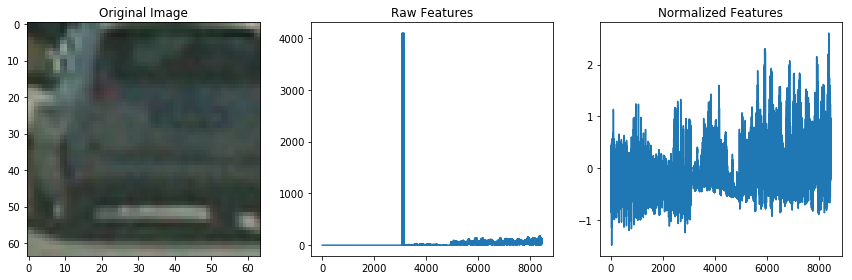

In [18]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_features)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_features)
car_ind = np.random.randint(0, len(vehicle_files))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(vehicle_files[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X_features[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

# Apply Support Vector Machine (SVM) to train a classifier

### SVM Hyperparameters Tuning

In [10]:
parameters = {'C':[0.08,0.1,0.2,0.4],'penalty':['l2'],'loss':['hinge','squared_hinge']}
X_scaler = StandardScaler().fit(X_features)
X_features = X_scaler.transform(X_features)
svr = LinearSVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_features, y_features)

print('Best Training accuracy:  {} with Best parameters: {}'.format(clf.best_score_,clf.best_params_))

Best Training accuracy:  0.8841779279279279 with Best parameters: {'C': 0.08, 'loss': 'squared_hinge', 'penalty': 'l2'}


### Train a classifier with best parameters

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                            test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train)            
X_test = X_scaler.transform(X_test)

svc = LinearSVC(C = 0.08, penalty = 'l2', loss = 'squared_hinge').fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)

print('Best validation accuracy: {}'.format(accuracy))

Best validation accuracy: 0.9831081081081081


In [37]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 64  # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

vehicle_features = extract_features(vehicle_files, color_space, spatial_size, hist_bins,hist_range, orient,
                                    pix_per_cell, cell_per_block,hog_channel,spatial_feat, hist_feat, hog_feat)
print('Shape of the vehicle features: {}'.format(vehicle_features.shape))

non_vehicle_features = extract_features(non_vehicle_files, color_space, spatial_size, hist_bins,hist_range, orient,
                                    pix_per_cell, cell_per_block,hog_channel,spatial_feat, hist_feat, hog_feat)
print('Shape of the non-vehicle features: {}'.format(non_vehicle_features.shape))

X_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print('Shape of the entire dataset: {}'.format(X_features.shape))

y_features = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                            test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train)            
X_test = X_scaler.transform(X_test)

svc = LinearSVC(C = 0.08, penalty = 'l2', loss = 'hinge').fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)

print('Best validation accuracy: {}'.format(accuracy))

Shape of the vehicle features: (8792, 8556)
Shape of the non-vehicle features: (8968, 8556)
Shape of the entire dataset: (17760, 8556)
Best validation accuracy: 0.986204954954955


In [39]:
scaler = StandardScaler().fit(X_features)
import pickle
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
svc_pickle = {}
svc_pickle["X_features"] = X_features
svc_pickle["y_features"] = y_features
svc_pickle['svc'] = svc
svc_pickle['scaler'] = scaler
pickle.dump( svc_pickle, open( "./svc_pickle3.p", "wb" ) )

### Search and Classify

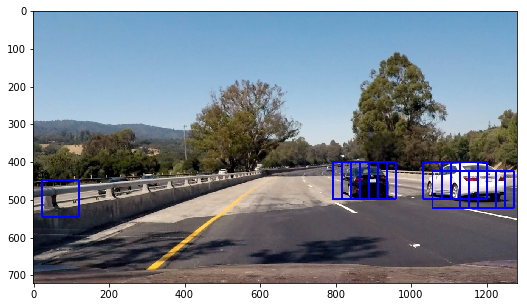

In [30]:
image = mpimg.imread( './test_images/test4.jpg')
copy_image = np.copy(image)
draw_image = np.copy(image)
#matplotlib image will read .jpg images in on a scale of 0 to 255 .but I extracted training
#data from .png images (scaled 0 to 1 by mpimg)
image = image.astype(np.float32)/255.0  

y_start_stop = [400,600]  # Min and max in y to search in sliding windows

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=True,
                             hist_feat=True, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=3)
fig = plt.figure(figsize=(10, 5))
plt.imshow(window_img)
plt.show()

### Multiple Detections & False Positives

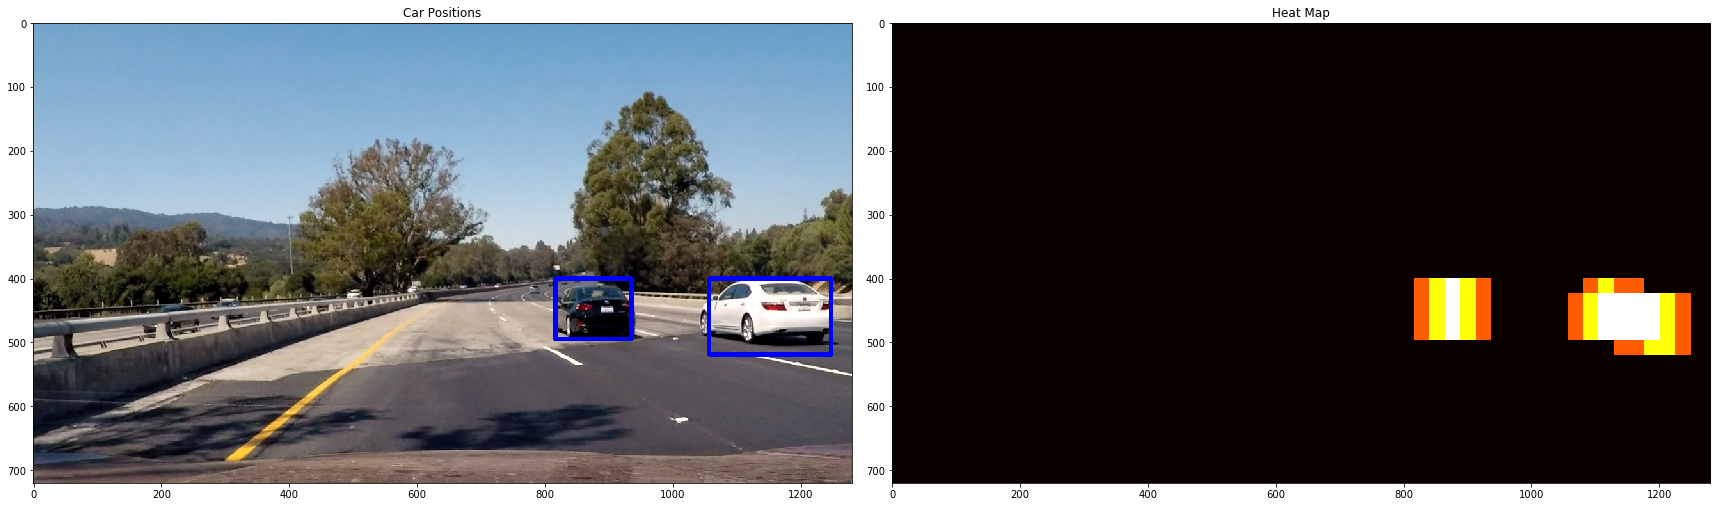

In [31]:
heat_map = np.zeros_like(image[:,:,0]).astype(np.float)
heat_map = add_heat(heat_map, hot_windows)
# Apply threshold to help remove false positives
heat_map = apply_threshold(heat_map,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(copy_image, labels)

fig = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [3]:
import pickle
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle3.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
scaler = dist_pickle["scaler"]
X_features = dist_pickle["X_features"]
y_features = dist_pickle["y_features"]

## Hog Sub-sampling Window Search

In [32]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
image = mpimg.imread( './test_images/test4.jpg')

#matplotlib image will read .jpg images in on a scale of 0 to 255 .but I extracted training
#data from .png images (scaled 0 to 1 by mpimg)
image = image.astype(np.float32)/255.0 
copy_image = np.copy(image)
y_start_stop = [400,600]
scale = 1.6
draw_img,hot_windows1,windows1 = find_cars(image, svc, scaler, scale = 1.0, x_start_stop=[None, None], y_start_stop=[400,520],
                                window=64, cells_per_step=2,color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block)
draw_img,hot_windows2,windows2 = find_cars(image, svc, scaler, scale = 1.5, x_start_stop=[None, None], y_start_stop=[400,600],
                                window=64, cells_per_step=2,color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block)

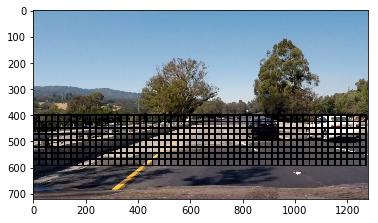

In [33]:
#img = draw_sliding_windows(image, windows1)
img = draw_sliding_windows(image, windows2)
plt.imshow(img)

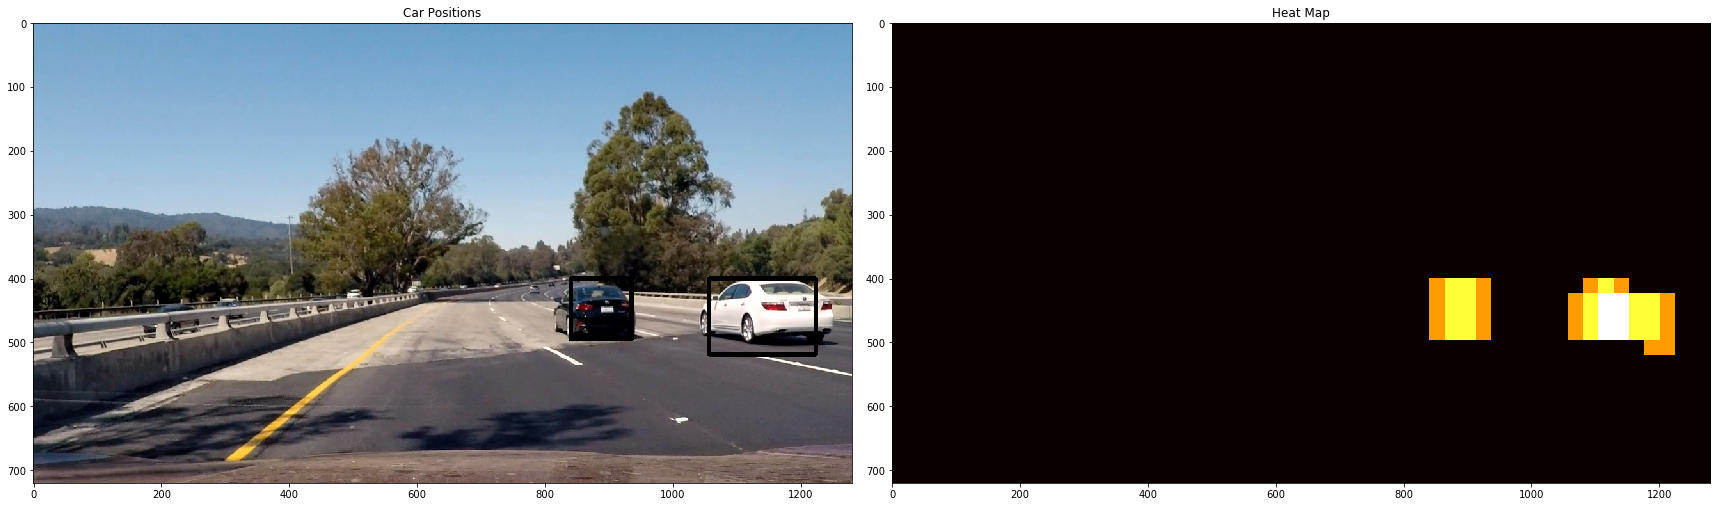

In [34]:
hot_windows=[]
#hot_windows.extend(hot_windows1)
hot_windows.extend(hot_windows2)
heat_map = np.zeros_like(image[:,:,0]).astype(np.float)
heat_map = add_heat(heat_map, hot_windows)
# Apply threshold to help remove false positives
heat_map = apply_threshold(heat_map,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(copy_image, labels)

fig = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

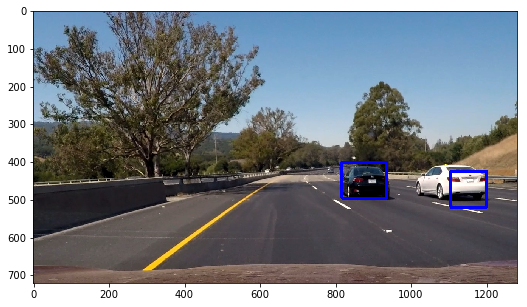

In [8]:
import vehicle_detection
x_start_stop=[None, None]
y_start_stop = [400,600] 
xy_window=(64, 64)
xy_overlap=(0.75, 0.75)
vehicle_detector = vehicle_detection.VehicleDetector(color_space=color_space,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,
                                  spatial_size=spatial_size,
                                  hist_bins=hist_bins,
                                  spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,
                                  hog_feat=hog_feat,
                                  y_start_stop=y_start_stop,
                                  x_start_stop=x_start_stop,
                                  xy_window=xy_window,
                                  xy_overlap=xy_overlap,
                                  heat_threshold = 1,
                                  scaler=scaler,
                                  classifier=svc,
                                  scale = 1.5,
                                  cells_per_step = 2) 

test_image_path_1 = './test_images/test6.jpg'
test_image_1 = mpimg.imread(test_image_path_1)
output_1 = vehicle_detector.detect(test_image_1)
fig = plt.figure(figsize=(10, 5))
plt.imshow(output_1)

In [5]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 64  # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
import vehicle_detection
x_start_stop=[700, None]
y_start_stop = [400,620] 
xy_window=(64, 64)
xy_overlap=(0.75, 0.75)
vehicle_detector_video = vehicle_detection.VehicleDetector(color_space=color_space,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,
                                  spatial_size=spatial_size,
                                  hist_bins=hist_bins,
                                  spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,
                                  hog_feat=hog_feat,
                                  y_start_stop=y_start_stop,
                                  x_start_stop=x_start_stop,
                                  xy_window=xy_window,
                                  xy_overlap=xy_overlap,
                                  heat_threshold = 10,
                                  scaler=scaler,
                                  classifier=svc,
                                  scale = 1.5,
                                  cells_per_step = 2) 
output_file = './processed_project_video.mp4'
input_file = './project_video.mp4'

clip = VideoFileClip(input_file)
#clip = VideoFileClip(input_file).subclip(25,29)
out_clip = clip.fl_image(vehicle_detector_video.detect)
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [29:41<00:01,  1.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 



##  Sliding Window Search

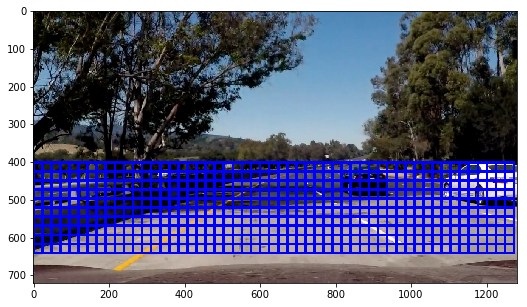

In [6]:
image = mpimg.imread('./test_images/test5.jpg')
copy_image = np.copy(image)


windows = slide_window(copy_image, xy_window=(96, 96), xy_overlap=(0.75, 0.75), y_start_stop=[400, 650])
#print(windows)
img = draw_sliding_windows(image, windows)
fig = plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.show()